# Lecture 3 - Neural network deep dive

> A deep dive into optimising neural networks with stochastic gradient descent

## Learning objectives

* Understand what stochastic gradient descent is and how to minimise functions with it in PyTorch
* Understand all the ingredients needed to define a `Learner` in fastai

## References

* This lecture draws heavily from Chapter 4 of [_Deep Learning for Coders with fastai & PyTorch_](https://github.com/fastai/fastbook) by Jeremy Howard and Sylvain Gugger. The main difference is the use of a tabular jet tagging dataset instead of MNIST to showcase how all the elements of a `Learner` are combined.

## Imports

In [114]:
import torch
from datasets import load_dataset
from fastai.tabular.all import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm

In [3]:
import datasets

# Suppress logs to keep things tidy
datasets.logging.set_verbosity_error()

## A real-world example

So far we've focused on optimising simple quadratic functions, but let's now tackle a real-world problem using neural networks! We'll use the same dataset from lecture 1 that contains jets of top-quarks and QCD background. As usual, we'll load the dataset from the Hugging Face Hub and convert it to a Pandas `DataFrame` via the `to_pandas()` method:

In [4]:
nsubjet_ds = load_dataset("dl4phys/top_tagging_nsubjettiness")
df = nsubjet_ds["train"].to_pandas()
df.head()

  0%|          | 0/3 [00:00<?, ?it/s]

,pT,mass,tau_1_0.5,tau_1_1,tau_1_2,tau_2_0.5,tau_2_1,tau_2_2,tau_3_0.5,tau_3_1,...,tau_4_0.5,tau_4_1,tau_4_2,tau_5_0.5,tau_5_1,tau_5_2,tau_6_0.5,tau_6_1,tau_6_2,label
0,543.633944,25.846792,0.165122,0.032661,0.002262,0.048830,0.003711,0.000044,0.030994,0.001630,...,0.024336,0.001115,0.000008,0.004252,0.000234,7.706005e-07,0.000000,0.000000,0.000000e+00,0
1,452.411860,13.388679,0.162938,0.027598,0.000876,0.095902,0.015461,0.000506,0.079750,0.009733,...,0.056854,0.005454,0.000072,0.044211,0.004430,6.175314e-05,0.037458,0.003396,3.670517e-05,0
2,429.495258,32.021091,0.244436,0.065901,0.005557,0.155202,0.038807,0.002762,0.123285,0.025339,...,0.078205,0.012678,0.000567,0.052374,0.005935,9.395772e-05,0.037572,0.002932,2.237277e-05,0
3,512.675443,6.684734,0.102580,0.011369,0.000170,0.086306,0.007760,0.000071,0.068169,0.005386,...,0.044705,0.002376,0.000008,0.027895,0.001364,4.400042e-06,0.009012,0.000379,6.731099e-07,0
4,527.956859,133.985415,0.407009,0.191839,0.065169,0.291460,0.105479,0.029753,0.209341,0.049187,...,0.143768,0.033249,0.003689,0.135407,0.029054,2.593460e-03,0.110805,0.023179,2.202088e-03,0


### Preparing the data

In lecture 1, we used the `TabularDataLoaders.from_df()` method to quickly create dataloaders for the train and validation sets. In this lecture, we'll take a different approach. We'll first create tensors of the features and labels, wrap them as a PyTorch `Dataset`, and finally create the dataloaders using the generic `DataLoaders` class from fastai.

To get started, we'll need to split our data into a training and validation sets. We can do this quickly via the `train_test_split()` function from scikit-learn:

In [46]:
train_df, valid_df = train_test_split(df, random_state=42)
train_df.shape, valid_df.shape

((908250, 21), (302750, 21))

This has allocated 75% of our original dataset to `train_df` and the remainder to `valid_df`. Now that we have these `DataFrames`, the next thing we'll need are tensors for the features $(p_T, m, \tau_1^{(0.5)},\ldots)$ and labels. PyTorch provides a handy `from_numpy()` method that allows us to quickly convert the values of a `DataFrame` to tensors:

In [41]:
scaler = MinMaxScaler()

In [47]:
# Slice out all feature columns and cast to float32
train_x = torch.from_numpy(scaler.fit_transform(train_df.iloc[:, :-1].values)).float()
# Slice out the label column and convert to matrix of shape (num_examples, 1)
train_y = torch.from_numpy(train_df.iloc[:, -1].values)
# Sanity check on the shapes
train_x.shape, train_y.shape

(torch.Size([908250, 20]), torch.Size([908250]))

In [48]:
train_x[0]

tensor([6.1467e-01, 3.4553e-01, 2.0827e-01, 6.1930e-02, 2.9217e-02, 1.1426e-01,
        3.9722e-02, 3.0127e-02, 1.1553e-01, 4.4638e-02, 3.7694e-02, 1.1224e-01,
        5.0610e-02, 4.7183e-02, 7.6042e-02, 4.5295e-03, 2.0119e-05, 5.5926e-02,
        2.8786e-03, 8.6186e-06])

## NN from scratch

In [78]:
import math

weights = torch.randn(20, 2) / math.sqrt(20)
weights.requires_grad_()
bias = torch.zeros(2, requires_grad=True)

In [79]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [80]:
bs = 1024  # batch size

xb = train_x[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-0.5815, -0.8188], grad_fn=<SelectBackward0>) torch.Size([1024, 2])


In [81]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [82]:
yb = train_y[0:bs]
print(loss_func(preds, yb))

tensor(0.7231, grad_fn=<NegBackward0>)


In [83]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [84]:
print(accuracy(preds, yb))

tensor(0.5020)


In [85]:
n

908250

In [86]:
from IPython.core.debugger import set_trace

lr = 1e-2  # learning rate
epochs = 2  # how many epochs to train for
n = len(train_df)

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = train_x[start_i:end_i]
        yb = train_y[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [87]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.5866, grad_fn=<NegBackward0>) tensor(0.8570)


## Refactor using torch.nn.functional

In [88]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [89]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.5866, grad_fn=<NllLossBackward0>) tensor(0.8570)


## Refactor using nn.Module

In [90]:
from torch import nn

class LogisticRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(20, 2) / math.sqrt(20))
        self.bias = nn.Parameter(torch.zeros(2))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [91]:
model = LogisticRegressor()

print(loss_func(model(xb), yb))

tensor(0.6916, grad_fn=<NllLossBackward0>)


In [92]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = train_x[start_i:end_i]
            yb = train_y[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [93]:
print(loss_func(model(xb), yb))

tensor(0.5771, grad_fn=<NllLossBackward0>)


In [94]:
accuracy(model(xb), yb)

tensor(0.8560)

### Refactor using optim

In [95]:
from torch import optim

In [118]:
def get_model():
    model = LogisticRegressor()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = train_x[start_i:end_i]
        yb = train_y[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.7049, grad_fn=<NllLossBackward0>)
tensor(0.5792, grad_fn=<NllLossBackward0>)


## Refactor using Dataset

In [119]:
from torch.utils.data import TensorDataset

In [120]:
train_ds = TensorDataset(train_x, train_y)

In [101]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.5940, grad_fn=<NllLossBackward0>)


### Refactor using DataLoader

In [103]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(train_x, train_y)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

In [104]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.5713, grad_fn=<NllLossBackward0>)


### Add validation

In [121]:
train_ds = TensorDataset(train_x, train_y)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

# Slice out all feature columns and cast to float32
valid_x = torch.from_numpy(scaler.fit_transform(valid_df.iloc[:, :-1].values)).float()
# Slice out the label column and convert to matrix of shape (num_examples, 1)
valid_y = torch.from_numpy(valid_df.iloc[:, -1].values)
valid_ds = TensorDataset(valid_x, valid_y)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [122]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.6379)
1 tensor(0.5772)


In [128]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    acc = accuracy(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb), acc.item()

In [132]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in tqdm(train_dl):
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums, accs = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_acc = np.sum(np.multiply(accs, nums)) / np.sum(nums)

        print(epoch, val_loss, val_acc)

In [133]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [134]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

  0%|          | 0/887 [00:00<?, ?it/s]

0 0.6251985956793674 0.8593955408599532


  0%|          | 0/887 [00:00<?, ?it/s]

1 0.5675691612205852 0.8616317094732768


## Switch to NN

In [136]:
model = nn.Sequential(
    nn.Linear(20, 200),
    nn.ReLU(),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Linear(200, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, 2),
)
lr = 1e-3
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

  0%|          | 0/887 [00:00<?, ?it/s]

0 0.6895127527026673 0.8562180017491788


  0%|          | 0/887 [00:00<?, ?it/s]

1 0.676258602224235 0.8750156895994254


## Fasti style

In [137]:
dls = DataLoaders(train_dl, valid_dl)

In [142]:
learn = Learner(dls, model, loss_func, opt_func=SGD, metrics=[accuracy])

SuggestedLRs(valley=0.010964781977236271)

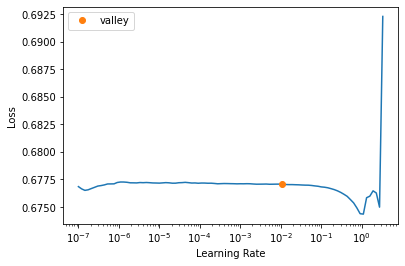

In [143]:
learn.lr_find()

In [144]:
learn.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.611372,0.597583,0.869870,00:11
1,0.478586,0.475628,0.870259,00:11


## Down to here

From these tensors we can now create a PyTorch `Dataset`. These objects need to return a tuple of $(x,y)$ pairs when indexed, and we can achieve this by simply combining a Python `list` with the `zip` function:

In [443]:
train_dset = list(zip(train_x, train_y))
x, y = train_dset[0]
x.shape, y

(torch.Size([20]), tensor([1]))

This look good for a single example in the dataset, so let's also do the same steps for the validation set:

In [444]:
valid_x = torch.from_numpy(valid_df.iloc[:, :-1].values).float()
valid_y = torch.from_numpy(valid_df.iloc[:, -1].values).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [481]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# train_x, valid_x = torch.from_numpy(scaler.fit_transform(train_x)).float(), torch.from_numpy(scaler.fit_transform(valid_x)).float()

### Initialise the parameters

Next we need to a way to randomly initialize the parameters of the models we'll create. To do so, we can create a simple helper function:

In [446]:
def init_params(size, std=1.0):
    return (torch.randn(size) * std).requires_grad_()


set_seed(666)
weights = init_params((20, 1))

Recall that in neural networks, a linear transformation is applied to each input `x`, so we'll also need to initialize the bias term:

In [447]:
set_seed(666)
bias = init_params(1)

With these parameters, we can create a simple linear classifier that predicts the jet class for a single example:

In [448]:
(x * weights.T).sum() + bias

tensor([-293.2585], grad_fn=<AddBackward0>)

Now in principle, we'd like to compute the predictions of _all_ the examples in our training set. We could do this with a Python for-loop, but this will be extremely slow and won't make use of the acceleration provided by a GPU. Instead, we'll use matrix multiplication to compute all the predictions in one go:

In [449]:
def linear_model(xb):
    return xb @ weights + bias

With this simple linear classifier, we can now compute the predictions over the whole training set:

In [450]:
preds = linear_model(train_x)
preds

tensor([[-1.0355],
        [-5.4567],
        [-0.9416],
        ...,
        [-1.4827],
        [-4.6571],
        [-7.6550]], grad_fn=<AddBackward0>)

Now that we have a model we can generate predictions from (step 2), the next thing we need is a loss function to measure how well these predictions compare to the true values.

## Binary cross entropy

Suppose 

In [518]:
def binary_cross_entropy(predictions, targets):
    predictions = predictions.sigmoid()
    print(predictions)
    return -torch.where(targets == 1, predictions, 1 - predictions).log().mean()

### SGD and mini-batches

In [501]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([11,  9,  1,  3,  0]),
 tensor([13, 10,  6,  5,  7]),
 tensor([ 2,  4,  8, 12, 14])]

In [502]:
weights = init_params((20, 1))
bias = init_params(1)

In [503]:
train_dl = DataLoader(train_dset, batch_size=1024, shuffle=True)

In [504]:
xb,yb = first(train_dl)
xb.shape, yb.shape

(torch.Size([1024, 20]), torch.Size([1024, 1]))

In [505]:
valid_dl = DataLoader(valid_dset, batch_size=1024)

In [506]:
preds = linear_model(xb)

In [516]:
preds[:10]

tensor([[408.8538],
        [173.9517],
        [366.2723],
        [181.1378],
        [297.0280],
        [155.0407],
        [148.4101],
        [290.3214],
        [110.0510],
        [242.1872]], grad_fn=<SliceBackward0>)

In [519]:
loss = binary_cross_entropy(preds[:10], yb[:10])
loss

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


tensor(inf, grad_fn=<NegBackward0>)

In [523]:
loss = nn.BCELoss()
loss(preds[:10], yb[:10])

RuntimeError: Found dtype Long but expected Float

In [520]:
F.binary_cross_entropy_with_logits(preds, yb)

RuntimeError: result type Float can't be cast to the desired output type Long

In [306]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([20]), tensor(0.), tensor([0.]))

In [307]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = binary_cross_entropy(preds, yb)
    loss.backward()

In [309]:
weights.grad.mean(), bias.grad

(tensor(0.), tensor([0.]))

In [337]:
simple_net = nn.Sequential(
    nn.Linear(20, 200),
    nn.ReLU(),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Linear(200, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, 2),
)

In [338]:
dls = DataLoaders(train_dl, valid_dl)

In [339]:
batch = first(dls.train)

In [340]:
batch[0].shape

torch.Size([1024, 20])

In [341]:
batch[1].shape

torch.Size([1024])

In [342]:
simple_net(batch[0]).shape

torch.Size([1024, 2])

In [343]:
binary_cross_entropy(simple_net(batch[0]), batch[1])

RuntimeError: The size of tensor a (1024) must match the size of tensor b (2) at non-singleton dimension 1

In [344]:
F.cross_entropy(simple_net(batch[0]), batch[1])

tensor(0.8711, grad_fn=<NllLossBackward0>)

In [348]:
learn = Learner(
    dls,
    simple_net,
    opt_func=SGD,
    loss_func=nn.CrossEntropyLoss(),
    metrics=[accuracy, RocAucBinary()],
)

In [349]:
learn.summary()

Sequential (Input shape: 1024 x 20)
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 200          
Linear                                    4200       True      
ReLU                                                           
Linear                                    40200      True      
ReLU                                                           
____________________________________________________________________________
                     1024 x 50           
Linear                                    10050      True      
ReLU                                                           
Linear                                    2550       True      
ReLU                                                           
____________________________________________________________________________
                     1024 x 2            
Linear                                    102        True      
____________________________________________

SuggestedLRs(valley=4.365158383734524e-05)

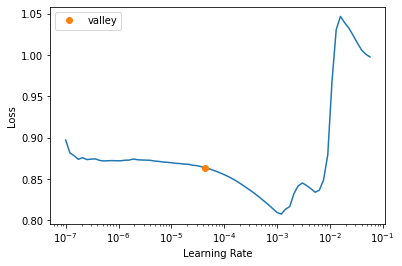

In [350]:
learn.lr_find()

In [351]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.313139,0.320223,0.874471,0.912726,00:05
1,0.305614,0.303472,0.880766,0.925295,00:05
2,0.302619,0.302697,0.880968,0.926046,00:05
